In [238]:

%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import pymudokon as pm
import optax

jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)
import pandas as pd

from jax.scipy.optimize import minimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [239]:
# d = 1, rhop = 1, e = 0.7, mu = 0, K = 10^3, shear rate = 1
names = ["nu", "p", "s", "T", "I", "CN", "k"]
df_k3 = pd.read_table("./DATA_SS/k1ex.data",sep=" ", skiprows=2,nrows=21, names = names)
df_k4 = pd.read_table("./DATA_SS/k1ex.data",sep=" ", skiprows=26,nrows=21, names = names)
df_k5 = pd.read_table("./DATA_SS/k1ex.data",sep=" ", skiprows=50,nrows=21, names = names)
df_k6 = pd.read_table("./DATA_SS/k1ex.data",sep=" ", skiprows=74,nrows=26, names= names)
df_k7 = pd.read_table("./DATA_SS/k1ex.data",sep=" ", skiprows=103,nrows=21, names= names)
df_k8 = pd.read_table("./DATA_SS/k1ex.data",sep=" ", skiprows=127,nrows=21, names= names)

In [240]:
def df_format(df,d,K):
    df["pstar"] = df["p"]*(d/K)
    df["mu"] = df["s"]/df["p"]

    df["e"] = 1./df["nu"] -1
    return df

In [246]:


df_k3 = df_format(df_k3,d=1,K=10**3)
df_k4 = df_format(df_k4,d=1,K=10**4)
df_k5 = df_format(df_k5,d=1,K=10**5)
df_k6 = df_format(df_k6,d=1,K=10**6)
df_k7 = df_format(df_k7,d=1,K=10**7)
df_k8 = df_format(df_k8,d=1,K=10**8)

In [289]:
import optax

def get_I_phi(phi, phi_c, I_phi):
    return I_phi * jnp.log(phi_c / phi)

def get_pressure(dgamma_dt, I, d, rho_p):
    return rho_p * ((dgamma_dt * d) / I) ** 2

@jax.jit
def get_p_I_impl(phi, phi_c, p_phi, I_phi, rho_p, dgamma_dt, d):

    I0 = get_I_phi(phi, phi_c, I_phi)

    p0 = get_pressure(dgamma_dt, I0, d, rho_p)
    
    def dilatancy(p):
        # p = sol
        # jax.debug.print("p {}",p)
        # sol = I_phi*jnp.log(phi_c / phi) - (dgamma_dt*d)/jnp.sqrt(p/rho_p)
        # return sol
        I = (dgamma_dt*d)/jnp.sqrt(p/rho_p)
        # sol = (1.0 + (d/10**3)*p/p_phi)*(phi_c - I_phi*I) - phi
        # return phi_c*(-())
        # p = d/10**8
        # sol =  phi_c*jnp.exp(p/p_phi)*jnp.exp(-I/I_phi) - phi
        sol =  phi_c*jnp.exp(-I/I_phi) - phi
        # jax.debug.print("sol {}",sol)
        return sol[0]
        # return p[0]
    
    def dilatancy_2(p):
        # p = sol
        # jax.debug.print("p {}",p)
        sol = -(I_phi**2)*2.0*jnp.log(phi_c / phi) + rho_p*(dgamma_dt*d)**2/p
        return sol[0]

    
    
    arr = jnp.array([I_phi]).astype(jnp.float64)
    # arr = jnp.array([10000000])
    # jax.debug.print("arr {} p0 {}",arr,p0)
    res = minimize(fun=dilatancy_2, x0= arr, method='BFGS',options={'maxiter': 1000})

    return res.x[0]


In [290]:


@jax.jit
def get_p_I(phi, phi_c, p_phi, I_phi, rho_p, dgamma_dt, d):
    
    I = get_I_phi(phi, phi_c, I_phi)
    p = get_pressure(dgamma_dt, I, d, rho_p)
    return p


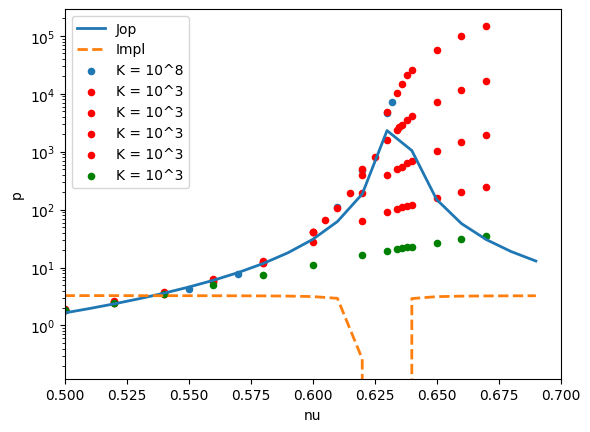

In [291]:
fig, ax = plt.subplots()
phi_stack = jnp.arange(0.5,0.7,0.01).astype(jnp.float64)
p_stack = []
p_impl_stack = []
for phi in phi_stack:
# for phi in [0.5]:
    p_impl = get_p_I_impl(
        phi=phi,
        phi_c =0.634,
        # p_phi = 0.33,
        p_phi=0.9,
       I_phi= 3.28,
    # I_phi=0.85,
       rho_p=1,
       dgamma_dt=1,
       d=1)
    p = get_p_I(
        phi=phi,
        phi_c =0.634,
        p_phi = 0.9,
        # p_phi=0.1,
       I_phi= 3.28,
    # I_phi=0.85,
       rho_p=1,
       dgamma_dt=1,
       d=1)

    p_stack.append(p)
    p_impl_stack.append(p_impl)

p_stack = jnp.array(p_stack)
p_impl_stack = jnp.array(p_impl_stack)



# print(p_stack)
ax.plot(phi_stack, jnp.nan_to_num(p_stack), ls="-",lw=2, label="Jop")
ax.plot(phi_stack, jnp.nan_to_num(p_impl_stack), ls="--",lw=2, label="Impl")
df_k8.plot(y="p", x="nu", kind="scatter", ax = ax, label="K = 10^8")
df_k7.plot(y="p", x="nu", kind="scatter", ax=ax,c="r", label="K = 10^3")
df_k6.plot(y="p", x="nu", kind="scatter", ax=ax,c="r", label="K = 10^3")
df_k5.plot(y="p", x="nu", kind="scatter", ax=ax,c="r", label="K = 10^3")
df_k4.plot(y="p", x="nu", kind="scatter", ax=ax,c="r", label="K = 10^3")
df_k3.plot(y="p", x="nu", kind="scatter", ax=ax,c="g", label="K = 10^3")
ax.set_yscale("log")


ax.set_xlim(0.5,0.7)

ax.legend()

In [288]:
# jnp.nan_to_num(p_st

a = jnp.array([0])
b = a*2

# b = jnp.float32(b)
b.max()

Array(0, dtype=int64)

In [218]:

# fig, ax = plt.subplots()

# last_volume_fraction_stack = []
# last_mu_stack = []

# for phi in jnp.arange(0.5,0.7,0.005):
#     carry, accumulate = pm.simple_shear_wrapper(
#         pm.MuI,
#         [
#             0.12,  # mu_s 0.381..
#             0.55, # mu_d 0.643..
#             0.2, # I0
#             0.634, # phi_c
#             3.28, # I_phi
#             1, # rho p (kg/m^3)
#             1, # d (m)
#             # 0.33, # p_phi
#             # # 0.01,
#             # # 0.9,
#             # 0.9 # p0
#         ],
#         target=1.0,
#         target_start=0.99,
#         dt=1e-3,
#         stress_ref= -1000.0 * jnp.eye(3).reshape(3, 3),
#         # volume_fraction=0.672,
#         volume_fraction=phi,
#         keys=("stress", "strain_rate","volume_fraction"),
#         store_every = 1,
#         is_target_strain_rate= False,
#         total_time=1.0,
        
#     )
    
#     stress_stack, strain_rate_stack,  volume_fraction_stack = accumulate
    
#     volume_fraction_stack = jnp.ones(len(stress_stack))*phi
    
#     pressure_stack = pm.get_pressure(stress_stack)
    
#     q_stack = pm.get_q_vm(stress_stack)
#     mu_stack = (q_stack/pressure_stack)/jnp.sqrt(3)
#     last_mu_stack.append(
#         mu_stack[-1]
#     )
    
#     last_volume_fraction_stack.append(
#         volume_fraction_stack[-1]
#     )
    
#     # ax.scatter(volume_fraction_stack,mu_stack,label=f"volume fraction = {phi}")


# ax.plot(jnp.array(last_volume_fraction_stack),jnp.array(last_mu_stack), ls="--",lw=2, label="Jop")

# df_k8.plot(y="mu", x="nu", kind="scatter", ax = ax, label="K = 10^8")
# df_k3.plot(y="mu", x="nu", kind="scatter", ax=ax,c="r", label="K = 10^3")

# ax.set_ylim(0.0,0.8)
# ax.set_xlim(0.5,0.7)


In [132]:
jax.scipy.stats

<module 'jax.scipy.stats' from '/home/retief/Projects/PyMudokonMPM/.venv/lib/python3.10/site-packages/jax/scipy/stats/__init__.py'>

(0.5, 0.7)

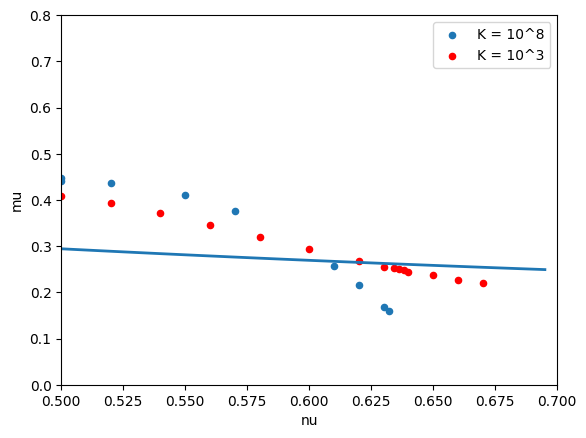

In [133]:

fig, ax = plt.subplots()

last_volume_fraction_stack = []
last_mu_stack = []

for phi in jnp.arange(0.5,0.7,0.005):
    carry, accumulate = pm.simple_shear_wrapper(
        pm.MuISoft,
        [
            0.12,  # mu_s 0.381.. 
            0.55, # mu_d 0.643..
            0.2, # I0
            0.634, # phi_c
            3.28, # I_phi
            1, # rho p (kg/m^3)
            1, # d (m)
            0.33, # p_phi
            # # 0.01,
            # 1.9,
            0.9 # p0
        ],
        target=1.0,
        dt=1e-3,
        stress_ref= -1000.0 * jnp.eye(3).reshape(3, 3),
        # volume_fraction=0.672,
        volume_fraction=phi,
        keys=("stress", "strain_rate","volume_fraction"),
        store_every = 1,
        is_target_strain_rate= False,
        total_time=1.0,
        
    )
    
    stress_stack, strain_rate_stack,  volume_fraction_stack = accumulate
    
    volume_fraction_stack = jnp.ones(len(stress_stack))*phi
    
    pressure_stack = pm.get_pressure(stress_stack)
    
    q_stack = pm.get_q_vm(stress_stack)
    mu_stack = (q_stack/pressure_stack)/jnp.sqrt(3)
    last_mu_stack.append(
        mu_stack[-1]
    )
    
    last_volume_fraction_stack.append(
        volume_fraction_stack[-1]
    )
    
    # ax.scatter(volume_fraction_stack,mu_stack,label=f"volume fraction = {phi}")


ax.plot(jnp.array(last_volume_fraction_stack),jnp.array(last_mu_stack), ls="-",lw=2, label="Jop")

df_k8.plot(y="mu", x="nu", kind="scatter", ax = ax, label="K = 10^8")
df_k3.plot(y="mu", x="nu", kind="scatter", ax=ax,c="r", label="K = 10^3")

ax.set_ylim(0.0,0.8)
ax.set_xlim(0.5,0.7)


In [ ]:

# carry, accumulate = pm.simple_shear_wrapper(
#     pm.MuISoft,
#     [
#         0.12,  # mu_s 0.381..
#         0.55, # mu_d 0.643..
#         0.2, # I0
#         0.634, # phi_c
#         3.28, # I_phi
#         2000, # rho p (kg/m^3)
#         0.0053, # d (m)
#         0.33, # p_phi
#         0.9 # p0
#     ],
#     target=1.0,
#     target_start=0.8,
#     dt=1e-3,
#     stress_ref= -1000.0 * jnp.eye(3).reshape(3, 3),
#     volume_fraction=0.672,
#     keys=("stress", "strain_rate","volume_fraction"),
#     store_every = 1,
#     is_target_strain_rate= True,
#     total_time=1.0,
    
# )

# stress_stack, strain_rate_stack,  volume_fraction_stack = accumulate

# fig_ax_stack = pm.plot_suite(
#     "./output/mu_I_ss_",
#     strain_rate_stack,
#     stress_stack,
#     volume_fraction_stack,
#     dt = 1e-3
#     )


In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(p_stack,q_stack)


In [ ]:
# mu_stack.min(),mu_stack.max()

In [ ]:
# I_stack.min(),I_stack.max()

In [ ]:


    # ax.plot(volume_fraction_stack,pressure_stack,label=f"volume fraction = {phi}")


In [ ]:
# # import partial
# # import vmap

# # @partial(jax.vmap, in_axes=(0, 0, None, None), out_axes=(0))
# # def get_I(shear_strain_rate, p, d0,rho_p):
    
    
# #     volumetric_strain_rate = -jnp.trace(shear_strain_rate)  # compressive strain rate is positive

# #     deviatoric_strain_rate = shear_strain_rate + (1 / 3.0) * volumetric_strain_rate * jnp.eye(3)

# #     dgamma_dt = jnp.sqrt(0.5 * (deviatoric_strain_rate @ deviatoric_strain_rate.T).trace())
    


# def get_I(stress_stack, strain_rate_stack,d,rho_p):
    
#     p_stack = pm.get_pressure(stress_stack)
#     dgamma_dt = pm.get_gamma(strain_rate_stack)
#     print(p_stack.shape)
#     vmap_get_I = jax.vmap(lambda dgamma_dt,p: (dgamma_dt*d)/jnp.sqrt(p/rho_p), in_axes=(0,0))
#     return vmap_get_I(dgamma_dt,p_stack)

# I_stack = get_I(stress_stack, strain_rate_stack, 0.0053, 2000)

# q_stack = pm.get_q_vm(stress_stack)

# p_stack = pm.get_pressure(stress_stack)


# mu_stack = (q_stack/p_stack)/jnp.sqrt(3)

In [ ]:
    # return 0
    # # sol = jnp.array([I0, p0])*0.
    # p = p0*0.5

    # # R = 1.0
    # # R = dilatancy(p)
    # # jax.debug.print("{}",R)
    # # R, sol = jax.lax.fori_loop(0, 10, NewtonRhapson, (R, p))
    # # R = R/jnp.linalg.vector_norm(R)
    # # m = jnp.mean(R)
    # # jax.debug.print("sol {} R {} m {}",sol, R,m)
    
    # # 
    # # solver = optax.lbfgs()

    # # sol =p0

    # # opt_state = solver.init(sol)

    # # value_and_grad = optax.value_and_grad_from_state(dilatancy)
    
    # # for _ in range(60):
    # #     # grad = jax.grad(loss)(sol)
    # #     value, grad = value_and_grad(sol,state = opt_state)
    # #     updates, opt_state = solver.update(
    # #         grad, opt_state, sol,value = value,grad=grad,value_fn=dilatancy)
    # #     sol = optax.apply_updates(sol, updates)
    # arr = jnp.array([p])
    # res = minimize(fun=dilatancy, x0= arr, method='BFGS')
    # # return res.x
    # return 0